In [2]:
import os, glob
import pickle
import numpy as np
import nibabel as nib
import pandas as pd

## Process MnMs dataset

In [2]:
size = 192
voxel = 1.25
save_pth = 'data/'

In [5]:
def resample(img, scale):

    if img.dtype == 'int64':
        img = tr.rescale(img.astype(float), (scale,scale,1),order=0,anti_aliasing=False)
    else:
        img = tr.rescale(img, (scale,scale,1))
    if len(img.shape)<3:
        img = np.expand_dims(img,2)
    return img


def center_crop(img, size):
    x, y = img.shape[:2]
    startx = x//2-(size//2)
    starty = y//2-(size//2)    
    return img[startx:startx+size,starty:starty+size,...]

def padding(img,size):
    # pad the image to a specific size
    x, y, z = img.shape
    h_pad = (max(0, (size-x)//2),max(0, (size-x)//2+(size-x)%2))
    v_pad = (max(0, (size-y)//2),max(0, (size-y)//2+(size-y)%2))
    img = np.pad(img, (h_pad,v_pad,(0,0)), 'constant', constant_values=0)
    return img

def z_score_norm(img):
    
    return (img-img.mean())/img.std()


In [55]:
def load_MNMs(imgname, labname, size, voxel):
    nibimg = nib.load(imgname)
    scale = nibimg.header.get_zooms()[0]/voxel
    npimg = nibimg.get_fdata().astype(np.float32)

    niblab = nib.load(labname)
    nplab = niblab.get_fdata().astype(np.int64)
    nplab = (nplab==2) + (nplab==1)*2 + (nplab==3)*3
    idx = np.any(nplab,axis=(0,1,2))
    nplab = np.reshape(nplab[...,idx],nplab[...,idx].shape[:2]+(-1,))
    npimg = np.reshape(npimg[...,idx],npimg[...,idx].shape[:2]+(-1,))
    npimg = z_score_norm(center_crop(padding(resample(npimg,scale),size),size))
    nplab = center_crop(padding(resample(nplab,scale),size),size)
    return npimg, nplab

In [6]:
df = pd.read_csv('../WFP_Dataset/MNMs/201014_M&Ms_Dataset_Information_-_opendataset.csv')
files = os.listdir('../WFP_Dataset/MNMs/train')
for i in ['A','B','C','D']:
    npimgs = []
    nplabs = []
    case_code = df[df['Vendor']==i]['External code'].to_list()
    for case in case_code:
        if case in files and len(glob.glob('../WFP_Dataset/MNMs/train/'+ case +'/*.nii.gz'))>1:
            imgname = sorted(glob.glob('../WFP_Dataset/MNMs/train/'+ case +'/*.nii.gz'))[0]
            labname = sorted(glob.glob('../WFP_Dataset/MNMs/train/'+ case +'/*.nii.gz'))[1]
            npimg, nplab = load_MNMs(imgname, labname, size, voxel)
            npimgs.append(npimg.transpose(2,0,1))
            nplabs.append(nplab.transpose(2,0,1))
    
    np.save('MnM/c{}/imgs.npy'.format(i), npimgs, allow_pickle=True)
    np.save('MnM/c{}/labs.npy'.format(i), nplabs, allow_pickle=True)        

/home/gaozheyao/anaconda3/envs/pytorch1.8/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)
/home/gaozheyao/anaconda3/envs/pytorch1.8/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


## Process Prostate dataset

In [ ]:
size = 256
voxel = 0.6
save_pth = 'prostate/'

In [ ]:
def load_prostate(labname, size, voxel):
    
    if 'segmentation' in labname:
        imgname = labname.replace('_segmentation.nii','.nii')
    else:
        imgname = labname.replace('_Segmentation.nii','.nii')

    nibimg = nib.load(imgname)
    scale = nibimg.header.get_zooms()[0]/voxel
    npimg = resample(nibimg.get_fdata().astype(np.float32), scale)
    npimg = z_score_norm(center_crop(padding(npimg,size),size))
    
    niblab = nib.load(labname)
    nplab = resample(niblab.get_fdata().astype(np.int64), scale)
    nplab = center_crop(padding(nplab,size),size)
    nplab = nplab > 0
    
    return npimg, nplab

In [ ]:
centers = ['I2CVB',
 'ISBI',
 'ISBI_1.5',
 'UCL',
 'HK',
 'BIDMC']

root = '../prostate/'

for i, center in enumerate(centers):
    center = root+center
    files = os.listdir(center)
    npimgs = []
    nplabs = []
    for file in files:
        if 'segmentation' in file.lower():
            npimg, nplab = load_prostate(os.path.join(center,file), size, voxel)
            npimgs.append(npimg.transpose(2,0,1))
            nplabs.append(nplab.transpose(2,0,1))
    
    np.save(save_pth+'c{}/imgs.npy'.format(i+1), npimgs, allow_pickle=True)
    np.save(save_pth+'c{}/labs.npy'.format(i+1), nplabs, allow_pickle=True)

## Process MMWHS dataset

In [ ]:
def load_MMWHS(labname, size, size_z, voxel, voxel_z):
    
    niblab = nib.load(labname)
    scale = niblab.header.get_zooms()[0]/voxel
    scale_z = niblab.header.get_zooms()[-1]/voxel_z
    nplab = resample(niblab.get_fdata().astype(np.int64), scale, scale_z)
    nplab = center_crop(padding(nplab,size,size_z),size,size_z)
    nplab = (nplab == 205) * 1 + (nplab == 420) * 2 + (nplab == 500) * 3 + (nplab == 550) * 4 + \
        (nplab == 600) * 5 + (nplab == 820) * 6 + (nplab == 850) * 7
    
    imgname = labname.replace('label','image').replace('_1mm.nii','.nii')
    
    nibimg = nib.load(imgname)
    scale = nibimg.header.get_zooms()[0]/voxel
    scale_z = nibimg.header.get_zooms()[-1]/voxel_z
    npimg = resample(nibimg.get_fdata().astype(np.float32), scale, scale_z)
    npimg = z_score_norm(center_crop(padding(npimg,size,size_z),size,size_z))
    
    
    return npimg, nplab, nibimg.header

In [ ]:
centers = ['ct_test1','ct_test2','ct_test3','ct_test4']
for center in centers:
    npimgs = []
    nplabs = []

    for file in glob.glob(center +'/*'):
        if 'label' in file:
            npimg, nplab = load_MMWHS(file, size, size_z, voxel, voxel_z)
            npimgs.append(np.expand_dims(npimg,0))
            nplabs.append(np.expand_dims(nplab,0))

    np.save(center+'_imgs.npy', npimgs, allow_pickle=True)
    np.save(center+'_labs.npy', nplabs, allow_pickle=True)

## Process FeTS dataset

In [ ]:
modalities = ('flair', 't1ce', 't1', 't2')

# train
train_set = {
        'root': '../../../../data3/gaozheyao/MICCAI_FeTS2022_TrainingData',
        'partition': 'partitioning_3.csv', 
        'has_label': True
        } ## using the mannual partition file partitioning_3.csv


In [ ]:
def nib_load(file_name):
    if not os.path.exists(file_name):
        print('Invalid file name, can not find the file!')

    proxy = nib.load(file_name)
    data = proxy.get_data()
    proxy.uncache()
    return data


def process_i16(path, has_label=True):
    """ Save the original 3D MRI images with dtype=int16.
        Noted that no normalization is used! """
    label = np.array(nib_load(path + 'seg.nii.gz'), dtype='uint8', order='C')

    images = np.stack([
        np.array(nib_load(path + modal + '.nii.gz'), dtype='int16', order='C')
        for modal in modalities], -1)# [240,240,155]

    output = path + 'data_i16.pkl'

    with open(output, 'wb') as f:
        print(output)
        print(images.shape, type(images), label.shape, type(label))  # (240,240,155,4) , (240,240,155)
        pickle.dump((images, label), f)

    if not has_label:
        return


def process_f32b0(path):
    """ Save the data with dtype=float32.
        z-score is used but keep the background with zero! """

    label = np.array(nib_load(path + '_seg.nii.gz'), dtype='uint8', order='C')
    images = np.stack([np.array(nib_load(path + '_{}.nii.gz'.format(modal)), dtype='float32', order='C') for modal in modalities], -1)  # [240,240,155]
    output = path + '_data.pkl'
    mask = images.sum(-1) > 0
    for k in range(4):

        x = images[..., k]  #
        y = x[mask]

        # 0.8885
        x[mask] -= y.mean()
        x[mask] /= y.std()

        images[..., k] = x

    with open(output, 'wb') as f:
        print(output)

        pickle.dump((images, label), f)



def partition(dset):
    root, has_label = dset['root'], dset['has_label']
    file_pth = os.path.join(root, dset['partition'])
    
    df = pd.read_csv(file_pth, header=None)
    centers = list(set(df[1].to_list()[1:]))
    for center in centers:
#         img_lst, lab_lst = [], []
        flist = df[df[1]==center][0].to_list()
        for file in flist:
            path = os.path.join(root, file, file)
            process_f32b0(path)

In [ ]:
partition(train_set)

## Check processed data

In [3]:
from matplotlib import colors
import matplotlib.pyplot as plt

def show_result(npimg, nplab, slice=None, mask=True):
    if slice is not None:
        npimg = npimg[slice,...]
        nplab = nplab[slice,...].astype(int)
    
    nplab[nplab!=0] = 1
    true_masked = np.ma.masked_where(nplab == 0, nplab)
    color_lst = ['k','b','y','g']
    color_lst = ['k','brown']
    cmap = colors.ListedColormap(list(map(color_lst.__getitem__, np.unique(nplab)))[1:])

    plt.figure()
    plt.axis('off')
    plt.imshow(npimg.transpose(1,0), 'gray', interpolation='none')
    if mask:
        plt.imshow(true_masked.transpose(1,0), cmap, interpolation='none', alpha=0.8)

MnM Number of cases:  26 26


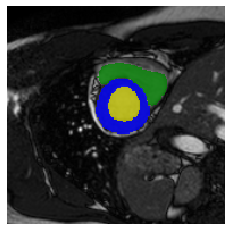

In [11]:
imgs = np.load('MnM/c3/imgs.npy', allow_pickle=True)
labs = np.load('MnM/c3/labs.npy', allow_pickle=True)
print('MnM Number of cases: ', len(imgs),len(labs))
show_result(imgs[7], labs[7], 14)

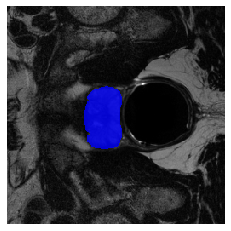

In [7]:
imgs = np.load('prostate/c3/imgs.npy',allow_pickle=True)
labs = np.load('prostate/c3/labs.npy',allow_pickle=True)
show_result(imgs[1],labs[1],11)